# Importing useful libraries and starting setup

In [1]:
#TBC which one are really used or not

#libraries importing

#pd for read doc & dataframe
import pandas as pd
import spacy
#os for files loading
import os
#import re for preprocessing
import re
#import wordcloud to nicely visualise most recurrent words
from wordcloud import WordCloud
#https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb
# importing CountVectorizer to make a bag of words model
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
#importing distance metrics to generate a cosine similarity matrix
# importing metrics computing polynomial_kernel with degree=1 and coef0=0
from sklearn.metrics.pairwise import linear_kernel
# importing metrics computing L2-normalized dot product of vectors
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.metrics.pairwise import cosine_similarity
# tf-idf functionality in sklearn.feature_extraction.text can produce normalized vectors,
# in which case cosine_similarity is equivalent to linear_kernel, only slower.
# source: https://scikit-learn.org/stable/modules/metrics.html


from nltk.tokenize import word_tokenize

#importing methods for lemmatization TBC by Emre
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

#NER methods
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tag import pos_tag
from nltk import ne_chunk_sents

#importint Counter to get words number from list
from collections import Counter

In [2]:
from typing import List

In [3]:
#models importing

#load only sm
nlp_sm = spacy.load('en_core_web_sm')

#for NEr
nltk.download('maxent_ne_chunker')
nltk.download('words')

stopwords_en = spacy.lang.en.stop_words.STOP_WORDS

# dealing with ValueError: [E088] Text of length 7539328 exceeds maximum of 1000000.
# The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input.
# This means long texts may cause memory allocation errors. If you're not using the parser or NER,
# it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters,
# so you can check whether your inputs are too long by checking `len(text)`.
nlp_sm.max_length = 8000000 #7539328

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Fra\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Fra\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [4]:
# LOADING FILES NB
START_PATH = os.path.dirname(os.getcwd())
NEWS_PATH = os.path.join(START_PATH + r'\assets\news_data.json')
CASE_PATH = os.path.join(START_PATH + r'\assets\case_data.json')
USECASES = os.path.join(START_PATH + r'\data\springboard_ai_usecases.csv')
#added for completeness but not used
ENTITIES_PATH = os.path.join(START_PATH + r'\data\custom_entities.csv')

news: pd.DataFrame = pd.read_json(NEWS_PATH)
news: pd.DataFrame = pd.json_normalize(news['data'])
case: pd.DataFrame = pd.read_json(CASE_PATH)
case: pd.DataFrame = pd.json_normalize(case['data'])

usecases: pd.DataFrame = pd.read_csv(USECASES, delimiter=';', encoding='cp1252')
#usecols=['Usecase Description', 'Type', 'Industry', 'Impact', 'Data Richness'],

# Preprocessing files to help the model

In [5]:
#taking small sample of 100 just for testing purpose
#summary is not considered being already part of text
publications = news.loc[:, ['title', 'tags', 'text',]].sample(100)

#merging into doc to get as many information as possible.
publications['doc'] =  publications.apply(lambda x: ".".join([x['title'], x['tags'], x['text']]), axis=1)
case['doc'] =  case.apply(lambda x: ".".join([x['name'], x['metrics'], x['description'], ]), axis=1)

## Creating set of NER

In [6]:
#creating a single ner set
nes = set()

#function to extract NER from text
def get_named_entities(text) -> set:
    doc = nlp_sm(text)
    named_entities = set([ent.text for ent in doc.ents])
    return named_entities

[[nes.add(n) for n in get_named_entities(text)] for text in publications.text]
len(nes)
#manually adding some words later discovered
nes.add('microsoft')

## Tokenization, lowering case, retaining alphabetic words & remove NERs

In [7]:
def tokenization(texts_doc: pd.Series) -> List[List[str]]:
    # Tokenize the article: tokens
    tokens =[word_tokenize(article) for article in texts_doc]
    # Convert the tokens into lowercase: lower_tokens
    lower_tokens = [[t.lower() for t in token] for token in tokens]
    # Retain alphabetic words: alpha_only
    alphas = [[t for t in lower_token if t.isalpha()] for lower_token in lower_tokens]
    # Remove all stop words: no_stops
    no_stops = [[t for t in alpha if t not in stopwords_en] for alpha in alphas]
    # Remove all NER
    no_nes = [[t for t in no_stop if t not in nes] for no_stop in no_stops]
    return no_nes

publications_tokens = tokenization(series = publications.doc)
cases_tokens = tokenization(series = case.doc)

## Lemmatization
Lemmatization for topic modelling and helping the processing

In [8]:
def lemmatization(docs_tokens: List[List[str]]) -> List[List[str]]:
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    # Instantiate the WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    # Lemmatize all tokens into a new list: lemmatized
    docs_lemmatized = [[wordnet_lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in doc_tokens]
                               for doc_tokens in docs_tokens]
    return docs_lemmatized

publications_lemmatized = lemmatization(publications_tokens)
cases_lemmatized = lemmatization(cases_tokens)

##  Overview of most common words
Identifying most common generic ai words to be removed helping the model to detect specific usecases in AI articles.

https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

### Identification for publications

In [75]:
#https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

def get_words_frequency(docs_lemmatized: List[List[str]], freq_min = None, freq_max = None) -> List[List[str]]:
    frequency_absolute =Counter([ item for elem in docs_lemmatized for item in elem])
    #DEV NOTE wordcloud to be replaced with better methods
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(frequency_absolute)
    #absolute frequency not needed
    #word_freq={k: v for k, v in sorted(word_cloud_dict.items(),reverse=True, key=lambda item: item[1])}
    #getting relative frequency in order
    rel_freq=wordcloud.words_
    rel_freq_filtered = rel_freq.copy()
    if freq_min is not None and freq_min > 0 and freq_min < 1:
        rel_freq_filtered = {k: v for k, v in rel_freq_filtered.items() if v > freq_min}
    if freq_max is not None and freq_max > 0 and freq_max < 1:
        rel_freq_filtered = {k: v for k, v in rel_freq_filtered.items() if v < freq_max}
    return rel_freq, rel_freq_filtered, wordcloud

[('s', 1.0), ('ai', 0.8045112781954887), ('say', 0.7443609022556391)]
[('great', 0.055639097744360905), ('believe', 0.055639097744360905), ('alphago', 0.055639097744360905)]


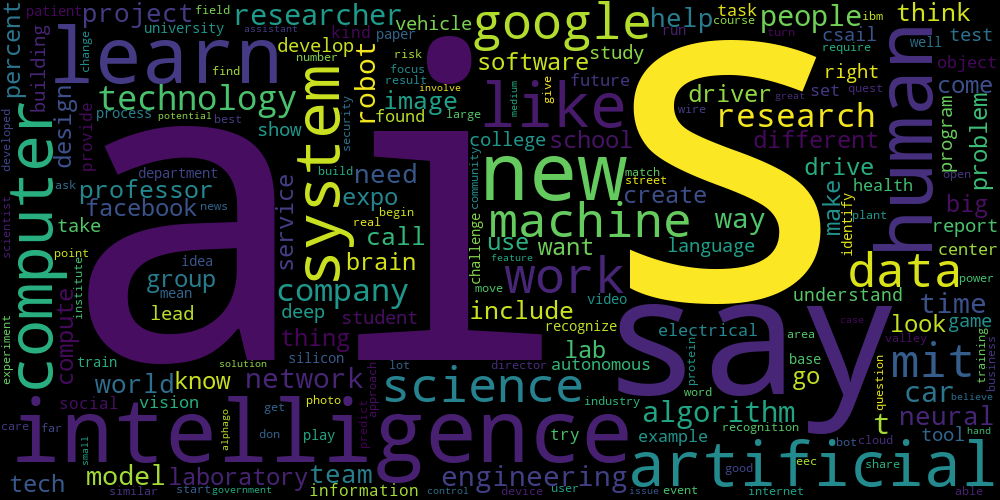

In [78]:
publication_freq, publication_freq_filtered, wordcloud = get_words_frequency(publications_lemmatized, freq_min=0.25, freq_max=0.75)
print(list(publication_freq.items())[:3])
print(list(publication_freq.items())[-3:])
wordcloud.to_image()

[('say', 0.7443609022556391), ('intelligence', 0.5353383458646617), ('new', 0.45864661654135336)]
[('company', 0.3082706766917293), ('researcher', 0.25413533834586466), ('t', 0.2511278195488722)]


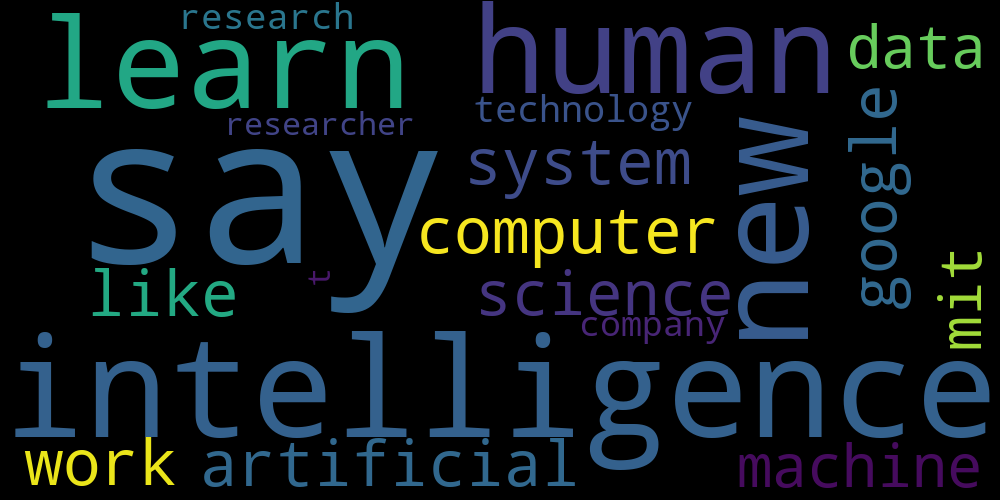

In [79]:
print(list(publication_freq_filtered.items())[:3])
print(list(publication_freq_filtered.items())[-3:])
wordcloud_filtered = WordCloud(width = 1000, height = 500).generate_from_frequencies(publication_freq_filtered)
wordcloud_filtered.to_image()

### Identification for cases

[('data', 1.0), ('customer', 0.8727272727272727), ('sale', 0.7454545454545455)]
[('audience', 0.03636363636363636), ('website', 0.03636363636363636), ('tag', 0.03636363636363636)]


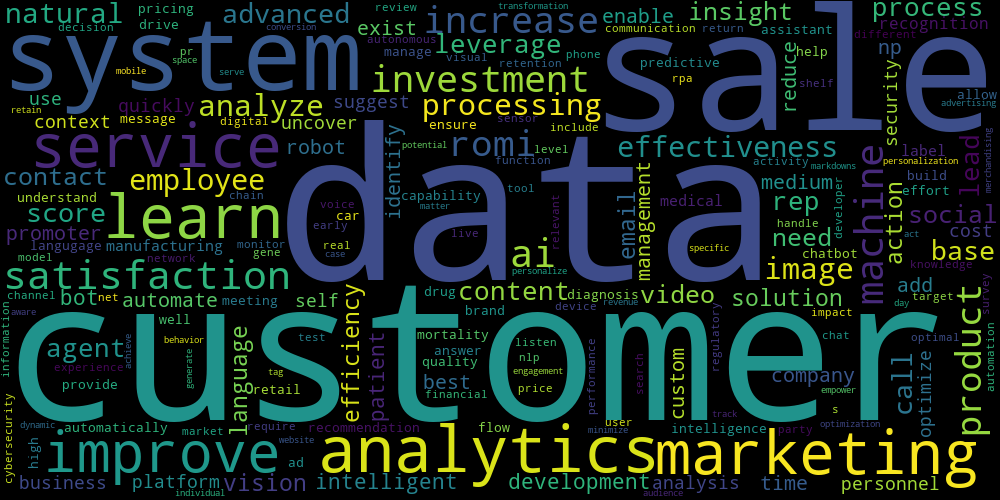

In [83]:
cases_freq, cases_freq_filtered, wordcloud = get_words_frequency(cases_lemmatized, freq_min=0.25, freq_max=0.75)
print(list(cases_freq.items())[:3])
print(list(cases_freq.items())[-3:])
wordcloud.to_image()

[('sale', 0.7454545454545455), ('system', 0.6363636363636364), ('analytics', 0.4727272727272727)]
[('ai', 0.2909090909090909), ('investment', 0.2545454545454545), ('increase', 0.2545454545454545)]


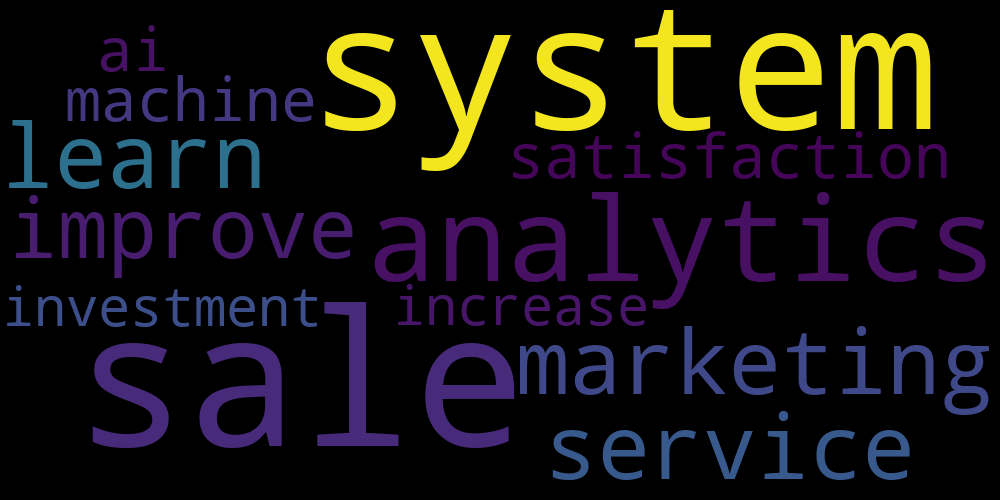

In [84]:
print(list(cases_freq_filtered.items())[:3])
print(list(cases_freq_filtered.items())[-3:])
wordcloud_filtered = WordCloud(width = 1000, height = 500).generate_from_frequencies(cases_freq_filtered)
wordcloud_filtered.to_image()

### Removal of most and least frequent words

In [87]:
publications_filtered = [[t for t in pub_lem if t in publication_freq_filtered.values()] for pub_lem in publications_lemmatized]
print(f'Publications words: {len(publications_filtered)}')
cases_filtered = [[t for t in case_lem if t in cases_freq_filtered.values()] for case_lem in cases_lemmatized]
print(f'Cases words: {len(cases_filtered)}')

Publications words: 100
Cases words: 122
